In [1]:
from dblayer import *

connect = PostgreSQLConnectionInfo(
    user = 'postgres',
    pwd = 'postgres',
    host = 'localhost',
    port = '5432',
    dbname = 'citydb'
    )

In [2]:
from dblayer.sim.pandangas import *

pg_reader = PandaNGasModelDBReader( connect )

In [3]:
net = pg_reader.get_net( network_id = 3000 )

In [4]:
net

This pandangas network includes the following parameter tables:
   - load (123 elements)
   - feeder (2 elements)
   - pipe (287 elements)
   - bus (277 elements)

In [6]:
db_access = DBAccess()
db_access.connect_to_citydb(connect)


FinalEnergy = db_access.map_citydb_object_class( 'FinalEnergy', table_name='nrg8_final_energy_ts', schema='citydb_view' )

ConvSystemToFinalEnergy = db_access.map_citydb_object_class( 'ConvSystemToFinalEnergy',
    table_name='nrg8_conv_sys_to_final_nrg', schema='citydb', user_defined = True
    )

Boiler = db_access.map_citydb_object_class( 'Boiler', table_name='nrg8_conv_system', schema='citydb' )

TerminalElement = db_access.map_citydb_object_class( 'TerminalElement', table_name='utn9_ntw_feat_term_elem', schema='citydb_view' )

NetworkToFeature = db_access.map_citydb_object_class( 'NetworkToFeature',
    table_name='utn9_network_to_network_feature', schema='citydb', user_defined = True
    )

final_energy_db_data = db_access.join_citydb_objects(
    [ 'FinalEnergy', 'ConvSystemToFinalEnergy', 'Boiler', 'TerminalElement', 'NetworkToFeature' ], 
    conditions = [
        FinalEnergy.id == ConvSystemToFinalEnergy.final_nrg_id,
        ConvSystemToFinalEnergy.conv_system_id == Boiler.id,
        Boiler.inst_in_ctyobj_id == TerminalElement.conn_cityobject_id,
        TerminalElement.id == NetworkToFeature.network_feature_id,
        NetworkToFeature.network_id == 3000        
        ]
    )

In [7]:
gas_demand = { data[3].name: data[0].ts_values_array for data in final_energy_db_data }

In [8]:
hour_of_day = 12

for index, load in net.load.iterrows():
    net.load['p_kW'][index] = gas_demand[load['name']][hour_of_day]

/home/user/.virtualenvs/integrcity/lib/python3.5/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


In [5]:
net.load.tail()

,name,bus,p_kW,min_p_Pa,scaling
118,gas_node132,gas_node132,10.0,2200.0,1.0
119,gas_node166,gas_node166,10.0,2200.0,1.0
120,gas_node79,gas_node79,10.0,2200.0,1.0
121,gas_node124,gas_node124,10.0,2200.0,1.0
122,gas_node104,gas_node104,10.0,2200.0,1.0


In [6]:
import pandangas.simulation as sim

p_nodes, m_dot_pipes, m_dot_nodes, gas = sim._run_sim( net, level = 'BP' )

In [7]:
p_nodes['gas_node153']

832.1

<IPython.core.display.Javascript object>


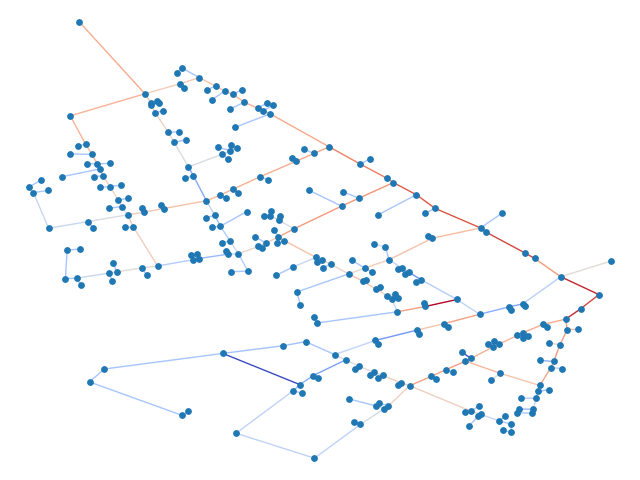

In [8]:
import math

%matplotlib notebook
import matplotlib.pyplot as plt
import networkx as nx

from pandangas.topology import create_nxgraph

#g = create_nxgraph( net )
g = create_nxgraph( net ).to_undirected()

def get_pipe_name( node_name1, node_name2 ):
    node_id1_str = node_name1[8:]
    node_id2_str = node_name2[8:]
    
    if int( node_id1_str ) < int( node_id2_str ):
        return 'gas_pipe{}-{}'.format( node_id1_str, node_id2_str )
    else:
        return 'gas_pipe{}-{}'.format( node_id2_str, node_id1_str )

nodes_pos = { n.name: pg_reader.geom_to_point2d( n.geom ).list() for n in pg_reader.network_nodes }

edge_color_list = [ math.log( math.fabs( m_dot_pipes[ get_pipe_name(e[0],e[1]) ] ) ) for e in g.edges ]
nx.draw( g, nodes_pos, edge_color=edge_color_list, edge_cmap=plt.cm.coolwarm, width=1, node_size=15 )

#node_color_list = [ math.log(math.fabs( p_nodes[n] )) for n in g.nodes ]
#nx.draw( g, nodes_pos, node_color=node_color_list, cmap=plt.cm.coolwarm, width=1, node_size=15 )

plt.show()

In [7]:
max(m_dot_pipes.values())

0.018766

In [11]:
net.load

,name,bus,p_kW,min_p_Pa,scaling
0,gas_node147,gas_node147,6.860618,2200.0,1.0
1,gas_node148,gas_node148,6.572530,2200.0,1.0
2,gas_node74,gas_node74,2.151342,2200.0,1.0
3,gas_node158,gas_node158,9.648893,2200.0,1.0
4,gas_node163,gas_node163,22.670208,2200.0,1.0
5,gas_node117,gas_node117,4.064309,2200.0,1.0
6,gas_node65,gas_node65,5.249685,2200.0,1.0
7,gas_node120,gas_node120,11.138371,2200.0,1.0
8,gas_node118,gas_node118,6.019573,2200.0,1.0
9,gas_node282,gas_node282,18.217513,2200.0,1.0
